In [1]:
# LSTM for Ford
import quandl
quandl.ApiConfig.api_key="Mev5v8Rr-58sWDopyvgh"
mydata = quandl.get("WIKI/F")
mydata = mydata.drop(['Volume','Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'], axis=1)
mydata.head()

,Open,High,Low,Close
Date,,,,
1972-06-01,66.91,67.00,66.25,66.38
1972-06-02,66.38,67.00,66.00,66.25
1972-06-05,66.25,66.88,66.00,66.25
1972-06-06,66.25,66.50,65.25,65.50
1972-06-07,65.50,65.88,65.13,65.13


In [70]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
# tutorial:https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# tutorial:https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# load
values = mydata.values
values = values.astype('float32')
# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 7)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31]], axis=1, inplace=True)
print(reframed.head(10))
# predicting next day open as var1(t)

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t+6)
1    0.592646   0.589268   0.594496   0.590015   0.568615
2    0.587858   0.589268   0.592218   0.588838   0.568615
3    0.586684   0.588188   0.592218   0.588838   0.575391
4    0.586684   0.584766   0.585384   0.582042   0.582166
5    0.579908   0.579184   0.584290   0.578690   0.579908
6    0.576565   0.576933   0.579734   0.574160   0.582166
7    0.572048   0.569010   0.564881   0.570717   0.578824
8    0.568615   0.571261   0.571715   0.570717   0.581082
9    0.568615   0.570181   0.576271   0.575247   0.574307
10   0.575391   0.583686   0.583106   0.584307   0.570874


In [109]:
# split into train and tets
values = reframed.values
train_size = int(len(values) * 0.67)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7737, 1, 4) (7737,) (3812, 1, 4) (3812,)


Train on 7737 samples, validate on 3812 samples
Epoch 1/10
 - 2s - loss: 0.1663 - val_loss: 0.1150
Epoch 2/10
 - 0s - loss: 0.0433 - val_loss: 0.0717
Epoch 3/10
 - 0s - loss: 0.0306 - val_loss: 0.0417
Epoch 4/10
 - 0s - loss: 0.0194 - val_loss: 0.0192
Epoch 5/10
 - 0s - loss: 0.0171 - val_loss: 0.0101
Epoch 6/10
 - 0s - loss: 0.0168 - val_loss: 0.0086
Epoch 7/10
 - 0s - loss: 0.0165 - val_loss: 0.0081
Epoch 8/10
 - 0s - loss: 0.0164 - val_loss: 0.0074
Epoch 9/10
 - 0s - loss: 0.0163 - val_loss: 0.0070
Epoch 10/10
 - 0s - loss: 0.0162 - val_loss: 0.0065


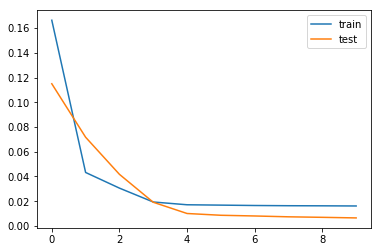

In [110]:
# LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [111]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE 
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.894


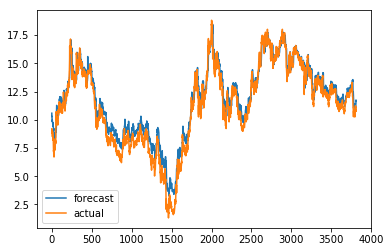

In [112]:
# plot
pyplot.plot(inv_yhat, label='forecast')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()